# **Problem Definition**  
The lid-driven cavity problem is a classic problem in fluid mechanics used to analyze momentum transfer in enclosed flows. It consists of a 2D square cavity filled with fluid, where:  

- Three walls are rigid with no-slip boundary conditions (zero fluid velocity).  
- The fourth wall (lid) moves tangentially with a unit velocity, driving the flow inside the domain.  

The objective is to use a Physics-Informed Neural Network (PINN) to predict the velocity fields inside the cavity.  

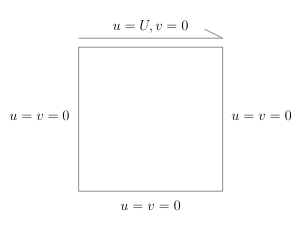

---

# **Governing Equations (Fluid Flow)**  
These equations describe how a fluid moves in a 2D space:  

### **1. Continuity Equation (Mass Conservation)**  
$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$
- Ensures that mass is conserved

### **2. Momentum Equation in the X-Direction (Navier-Stokes Eqn for 'u')**  
$$
u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} \frac{1}{\rho} - \nu \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) = 0
$$
- Describes how the horizontal velocity \( u \) changes due to:  
  - Fluid inertia,  
  - Pressure forces,  
  - Viscosity ($\nu$) (internal friction slowing it down)

### **3. Momentum Equation in the Y-Direction (Navier-Stokes Eqn for 'v')**  
$$
u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} \frac{1}{\rho} - \nu \left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) = 0
$$
- Describes how the vertical velocity \( v \) changes due to the same effects as in the \( x \)-direction.  



# **Boundary Conditions (How the Fluid Behaves at the Edges)**  
We consider a square domain: $$ 0 \leq x \leq 1, \quad 0 \leq y \leq 1 $$ with the following conditions:

### **1. Moving Lid (Top Boundary, y = 1)**  
- Velocity: u = 1, v = 0  
- The top wall moves tangentially, dragging the fluid along.  

### **2. All other Boundaries**  
- Velocity: u = 0, v = 0
- The fluid has zero velocity at the walls (no-slip condition).  

---

# **Approach**  

## **Stream Function & Pressure Fields**  
- Given an (x, y) coordinate, the model predicts two values:  
  - The Stream Function $ \psi(x, y) $  
  - The Pressure $ p(x, y) $

- The Stream Function $( \psi )$ determines the velocity components using:  

  $$  
  u = \frac{\partial \psi}{\partial y}, \quad v = -\frac{\partial \psi}{\partial x}  
  $$  



## **Model Training**  
- The PDEs introduced earlier have been arranged to equal zero.  
- We also know the velocity values at the boundaries (walls and lid).  

### **Dataset Creation**  
- The dataset consists of random (x, y) coordinates sampled from:  
  - Walls and lid (for boundary conditions)  
  - Inside the cavity (for enforcing PDEs)  

- Labels:  
  - For boundary points (walls & lid): Use known velocity boundary conditions.  
  - For interior points:  
    - The model predictions are substituted into the PDEs (continuity & momentum equations).  
    - Since the PDEs are set to zero, the labels for these points are all zeros.  



## **Loss Function & Optimization**  
- Mean Squared Error (MSE) Loss is used:  

  $$  
  \mathcal{L} = \text{MSE}(\text{Boundary Conditions}) + \text{MSE}(\text{PDEs})  
  $$  

- The network is trained to minimize this loss, ensuring it learns a solution that satisfies:  
  - Governing equations (PDEs) inside the cavity.  
  - Boundary conditions (BCs) at the walls and lid.  



Once trained, the model will predict accurate velocity fields from $ \psi $ and satisfy the Navier-Stokes equations for the entire domain.  





# IMPORTS:

In [ ]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from math import exp, sqrt,pi


import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

import tqdm as tqdm

# CONSTANTS

In [ ]:
rho = 1 # Density
nu = 0.01 # Viscosity

num_train_samples = 10000
num_bc_samples = 5000
num_plot_samples = 200
epochs = 6000
lr = 0.001

load_checkpoint = False

# MODEL

In [ ]:
class Swish(nn.Module):
        def __init__(self, inplace=True):
            super(Swish, self).__init__()
            self.inplace = inplace

        def forward(self, x):
            if self.inplace:
                x.mul_(torch.sigmoid(x))
                return x
            else:
                return x * torch.sigmoid(x)

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), Swish(),
            nn.Linear(20, 20), Swish(),
            nn.Linear(20, 20), Swish(),
            nn.Linear(20, 20), Swish(),
            nn.Linear(20, 20), Swish(),
            nn.Linear(20, 20), Swish(),
            nn.Linear(20, 20), Swish(),
            nn.Linear(20, 20), Swish(),
            nn.Linear(20, 20), Swish(),
            nn.Linear(20, 2)
        )

    def forward(self, x, y):
        input = torch.cat([x,y], axis = 1)
        output = self.net(input)
        return output


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)

mse_loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.003, betas = (0.9,0.99),eps = 10**-15)

# PDE

In [ ]:
def Pde(x,y,net):

  u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
  v = -1 * torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

  u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
  u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]


  v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
  v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
  v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
  v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]


  p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
  p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

  continuity_pde_out = u_x + v_y
  x_dir_ns_pde_out = u*u_x + v*u_y + p_x/rho - nu*(u_xx + u_yy)
  y_dir_ns_pde_out = u*v_x + v*v_y + p_y/rho - nu*(v_xx + v_yy)

  pde_out = [continuity_pde_out, x_dir_ns_pde_out, y_dir_ns_pde_out, u, v]
  return pde_out

In [ ]:
def get_uv(x,y,net_out):
  psi, p = torch.split(net_out, split_size_or_sections=1, dim=1)

  u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
  v = -1 * torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

  predicted_vel = torch.cat([u,v], axis = 1)
  return predicted_vel

# CREATING TRAINING POINTS FOR BOUNDARIES (LID, WALLS):

In [ ]:
# Lid BCs:
lid_train_pts = np.random.rand(num_bc_samples, 2)
lid_train_pts[:,1:2] = 1

lid_labels = np.zeros((num_bc_samples,2))
lid_labels[:,0:1] = 1

lid_train_pts_device = torch.from_numpy(lid_train_pts).float().to(device)
lid_train_pts_device.requires_grad = True
x_lid, y_lid = torch.split(lid_train_pts_device, split_size_or_sections=1, dim=1)  # input data for lid bc to network

lid_labels_device = torch.from_numpy(lid_labels).float().to(device)


# Left wall BCs:
lw_train_pts = np.random.rand(num_bc_samples, 2)
lw_train_pts[:,0:1] = 0

lw_labels = np.zeros((num_bc_samples,2))

lw_train_pts_device = torch.from_numpy(lw_train_pts).float().to(device)
lw_train_pts_device.requires_grad = True
x_lw, y_lw = torch.split(lw_train_pts_device, split_size_or_sections=1, dim=1)    # input data for lw bc to  network

lw_labels_device = torch.from_numpy(lw_labels).float().to(device)


# Right wall BCs:
rw_train_pts = np.random.rand(num_bc_samples, 2)
rw_train_pts[:,0:1] = 1

rw_labels = np.zeros((num_bc_samples,2))

rw_train_pts_device = torch.from_numpy(rw_train_pts).float().to(device)
rw_train_pts_device.requires_grad = True
x_rw, y_rw = torch.split(rw_train_pts_device, split_size_or_sections=1, dim=1)    # input data for rw bc to  network

rw_labels_device = torch.from_numpy(rw_labels).float().to(device)


# Lower wall BCs:
btm_train_pts = np.random.rand(num_bc_samples, 2)
btm_train_pts[:,1:2] = 0

btm_labels = np.zeros((num_bc_samples,2))

btm_train_pts_device = torch.from_numpy(btm_train_pts).float().to(device)
btm_train_pts_device.requires_grad = True
x_btm, y_btm = torch.split(btm_train_pts_device, split_size_or_sections=1, dim=1)    # input data for lower wall bc to  network

btm_labels_device = torch.from_numpy(btm_labels).float().to(device)


# CREATING TRAINING POINTS FOR INSIDE CAVITY:

In [ ]:
train_pts = np.random.rand(num_train_samples, 2)
train_pts_device = torch.from_numpy(train_pts).float().to(device)
train_pts_device.requires_grad = True

train_labels = np.zeros((num_train_samples,1))
train_labels_device = torch.from_numpy(train_labels).float().to(device)

# Training Loop:

In [ ]:
if load_checkpoint == True:
  checkpoint = torch.load('net.pth', map_location = device)
  net.load_state_dict(checkpoint)

In [ ]:
for epoch in range(epochs):

  optimizer.zero_grad()



  #----------------------------BOUNDARY CONDITION LOSS CALCULATION------------------------------#

  # lid:
  net_lid_bc_out = net(x_lid, y_lid)

  lid_predicted_vel = get_uv(x_lid, y_lid, net_lid_bc_out)
  j_lid = mse_loss_fn(lid_predicted_vel, lid_labels_device)

  # left-wall:
  net_lw_bc_out = net(x_lw, y_lw)
  lw_predicted = get_uv(x_lw, y_lw, net_lw_bc_out)
  j_lw = mse_loss_fn(lw_predicted, lw_labels_device)

  # right-wall:
  net_rw_bc_out = net(x_rw, y_rw)
  rw_predicted = get_uv(x_rw, y_rw, net_rw_bc_out)
  j_rw = mse_loss_fn(rw_predicted, rw_labels_device)

  # lower wall:
  net_btm_bc_out = net(x_btm, y_btm)
  btm_predicted = get_uv(x_btm, y_btm, net_btm_bc_out)
  j_btm = mse_loss_fn(btm_predicted, btm_labels_device)


  J_BC = j_lid + j_lw + j_rw + j_btm    # total BC loss
  #----------------------------------------------------------------------------------------------#



  #----------------------------PDE LOSS CALCULATION------------------------------#
  xy = train_pts_device
  x, y = torch.split(xy, split_size_or_sections=1, dim=1)
  xy.requires_grad = True

  output = net(x,y)
  psi = output[:,0:1]
  p = output[:,1:2]

  pde_outputs = Pde(x,y,net)

  j_continuity = mse_loss_fn(pde_outputs[0], train_labels_device)
  j_ns_x = mse_loss_fn(pde_outputs[1], train_labels_device)
  j_ns_y = mse_loss_fn(pde_outputs[2], train_labels_device)


  J_PDE = j_continuity + j_ns_x + j_ns_y
  #----------------------------------------------------------------------------------------------#



  total_loss = J_BC + J_PDE

  total_loss.backward()

  optimizer.step()

  with torch.autograd.no_grad():
    	print(epoch,"Training Loss:", total_loss.data)

  if epoch % 100 == 0:
    torch.save(net.state_dict(), 'net.pth')





0 Training Loss: tensor(0.5000, device='cuda:0')
1 Training Loss: tensor(0.5000, device='cuda:0')
2 Training Loss: tensor(0.5000, device='cuda:0')
3 Training Loss: tensor(0.4999, device='cuda:0')
4 Training Loss: tensor(0.4998, device='cuda:0')
5 Training Loss: tensor(0.4997, device='cuda:0')
6 Training Loss: tensor(0.4996, device='cuda:0')
7 Training Loss: tensor(0.4993, device='cuda:0')
8 Training Loss: tensor(0.4989, device='cuda:0')
9 Training Loss: tensor(0.4983, device='cuda:0')
10 Training Loss: tensor(0.4975, device='cuda:0')
11 Training Loss: tensor(0.4962, device='cuda:0')
12 Training Loss: tensor(0.4945, device='cuda:0')
13 Training Loss: tensor(0.4920, device='cuda:0')
14 Training Loss: tensor(0.4884, device='cuda:0')
15 Training Loss: tensor(0.4835, device='cuda:0')
16 Training Loss: tensor(0.4768, device='cuda:0')
17 Training Loss: tensor(0.4676, device='cuda:0')
18 Training Loss: tensor(0.4555, device='cuda:0')
19 Training Loss: tensor(0.4398, device='cuda:0')
20 Trainin

# PLOTTING:

In [ ]:
def contour(grid, x, y, z, title, levels=50):
    vmin = np.min(z)
    vmax = np.max(z)

    ax = plt.subplot(grid)
    ax.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    mappable = ax.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    ax.set_aspect('equal')  # Force square shape
    ax.set_title(title)

    cbar = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=10, shrink=0.8, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)

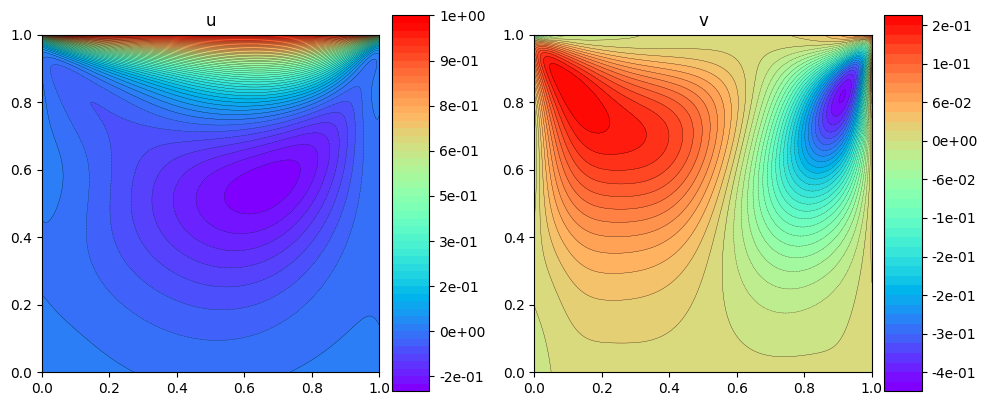

In [ ]:
x_coords = np.linspace(0, 1, num_plot_samples)
y_coords = np.linspace(0, 1, num_plot_samples)

x_m, y_m = np.meshgrid(x_coords, y_coords)
xy_coords = np.stack([x_m.flatten(), y_m.flatten()], axis=-1)
xy_coords_device = torch.from_numpy(xy_coords).float().to(device)
xy_coords_device.requires_grad = True
x_coord_list, y_coord_list = torch.split(xy_coords_device, split_size_or_sections=1, dim=1)


net.eval()
psi_p = net(x_coord_list, y_coord_list)
psi_plot, p_plot = [ psi_p[..., i].reshape(x_m.shape) for i in range(psi_p.shape[-1]) ]
psi_plot = psi_plot.detach().cpu().numpy()
p_plot = p_plot.detach().cpu().numpy()

velocities = get_uv(x_coord_list, y_coord_list, psi_p)
u_plot = velocities[:,0:1]
u_plot = u_plot.detach().cpu().numpy()
v_plot = velocities[:,1:2]
v_plot = v_plot.detach().cpu().numpy()
u_plot = u_plot.reshape(x_m.shape)
v_plot = v_plot.reshape(x_m.shape)

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[1, 1])  # Ensure equal widths

contour(gs[0], x_m, y_m, u_plot, 'u')
contour(gs[1], x_m, y_m, v_plot, 'v')

plt.tight_layout()
plt.show()


### Here is what the solution determined using Computational-Fluid-Dynamics software looks like:

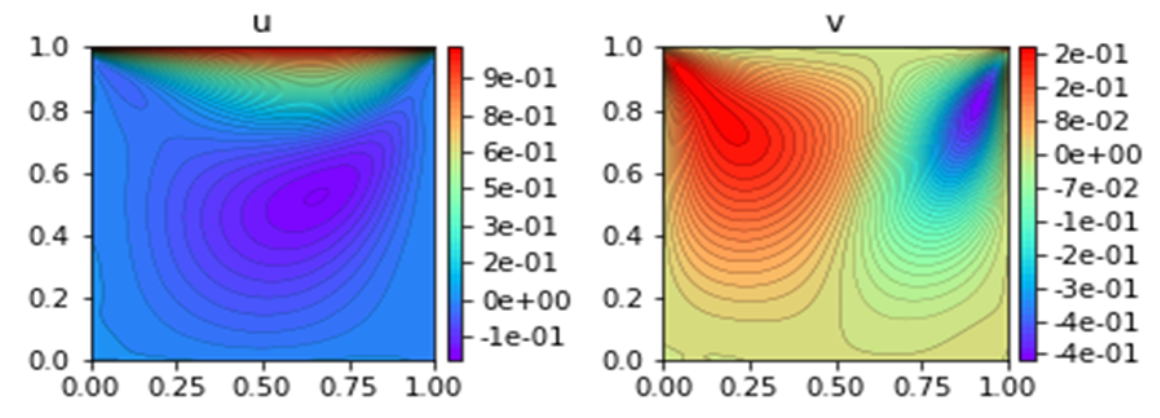

### The PINN was pretty close!
